In [1]:
from scipy import misc, stats
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from numpy.linalg import eigh # eigenvalue/vector

## 1_1. preprocessing: read images

In [2]:
img_width = 30
img_height = 30
file_path = 'Data_Train'
class_names = ['Class1', 'Class2', 'Class3']

In [56]:
def get_data(img_width = 30, img_height = 30,
             file_path = 'Data_Train', class_names = None,
             validation_ratio = 0.2, nb_samples = [1000,1000,1000]):
    if class_names is None: # testing, no answer
        img_path = [str(a)+'.bmp' for a in range(1, 601)]
        print(img_path)
        df = pd.DataFrame(index = range(len(img_path)), columns = range(img_height*img_width))
        for file, i in zip(img_path, range(len(img_path))):
            img = misc.imread(file_path + '/' + file).flatten()
            df.iloc[i] = img
        return df
            
    train_df = pd.DataFrame(columns = range(img_height*img_width))
    train_df['class'] = 0
    train_df
    for i in range(len(class_names)):
        path = file_path + '/' + class_names[i] + '/'
        print(path)
        class_img_files = os.listdir(path)[:nb_samples[i]]
        
        df = pd.DataFrame(index = range(len(class_img_files)), columns = range(img_height*img_width))
        for file, j in zip(class_img_files, range(len(class_img_files))):
            img_path = path + file
            img = misc.imread(img_path).flatten()
            df.iloc[j] = img
        df['class'] = class_names[i]
        train_df = train_df.append(df)

    np.random.seed(0)
    train_df = train_df.sample(frac=1)
    train_df, val_df = train_df.iloc[:int(len(train_df)*(1-validation_ratio))], train_df.iloc[int(len(train_df)*(1-validation_ratio)):]

    train_class = train_df['class']
    train_class.index = range(len(train_class))
    train_df = train_df.drop('class', axis=1)
    val_class = val_df['class']
    val_class.index = range(len(val_class))
    val_df = val_df.drop('class', axis=1)
    
    return train_df, train_class, val_df, val_class

In [38]:
train_df, train_class, val_df, val_class = get_data(file_path=file_path, class_names=class_names) 
#train_df, train_class, val_df, val_class = get_data(file_path=file_path, class_names=class_names, nb_samples=[1000,1000,100]) # unbalanced

Data_Train/Class1/
Data_Train/Class2/
Data_Train/Class3/


## 1_2. preprocessing: PCA

In [4]:
class PCA():
    
    def __init__(self, n_components=2, z_normalize=True):
        self.k = n_components
        self.P = None
        self.means = None
        self.stds = None
        self.cov = None
        self.eigen_values = None
        self.eigen_vectors = None
        self.z_normalize = z_normalize
        
    # or just use np.corrcoef(df_all.drop('class', axis=1).T)
    def _z_normalize(self, df):
        self.means = df.mean(axis=0)
        self.stds = df.std(axis=0)
        df = df.apply(lambda column: (column - np.mean(column))/np.std(column), axis=0)
        return df

    def compute_cov(self, df):
        # z-normalization
        if self.z_normalize:
            df = self._z_normalize(df)
            # when z-normalized, the cov is easy to compute
            cov = np.dot(df.T, df) / len(df)
            self.cov = cov
        else:
            self.cov = np.corrcoef(df.T)
        return self.cov
    
    def fit(self, X_train, centerize=True):
        """
        X_train: n_samples x n_features
        """
        cov = self.compute_cov(X_train)
        self.eigen_values, self.eigen_vectors = eigh(cov)
        #print(eigen_values.shape)
        eigen_pairs = [(np.abs(self.eigen_values[i]), self.eigen_vectors[:,i]) for i in range(len(self.eigen_values))]
        eigen_pairs.sort(reverse=True)
        
        # 選前k大的eigenvalue對應的eigenvector來作projection matrix
        # shape should be k * the flattened size of image
        P = np.zeros(shape=(self.k, len(eigen_pairs)))
        for i in range(self.k):
            P[i, :] = eigen_pairs[i][1]
        self.P = P
            
    def mapping(self, x):
        """
        x: n_samples * n_features
        
        return: k * n_samples
        """
        x = (x - self.means)/self.stds
        return np.dot(self.P, x)
    
    def show_importance_graph(self, name=None):
        tot = sum(np.abs(self.eigen_values))
        var_exp = [(i / tot) for i in sorted(np.abs(self.eigen_values), reverse=True)]
        cum_var_exp = np.cumsum(var_exp)
        print('top_10 cumsum:', cum_var_exp[:10])
        plt.bar(range(1, self.eigen_values.size + 1), var_exp, alpha=0.5, align='center',
                label='Individual')
        plt.step(range(1, self.eigen_values.size + 1), cum_var_exp, where='mid',
                 label='Cumulative')
        plt.title('Cumulative Importance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()
        if name is None:
            plt.savefig('fig-pca-var-exp.png', dpi=300)
        else:
            plt.savefig(name, dpi=300)
        plt.show()

### Let's see the difference between z-transformed PCA and non-z-transformed PCA

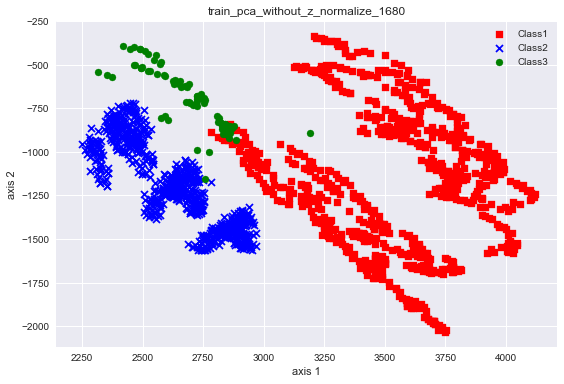

top_10 cumsum: [ 0.27010008  0.37351036  0.43553946  0.49129035  0.53582357  0.57185036
  0.60240169  0.62911655  0.65029473  0.66742224]


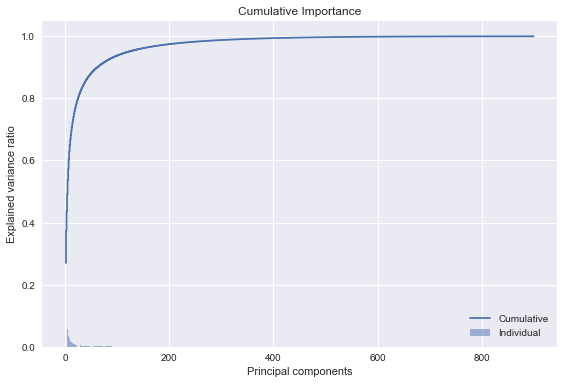

In [40]:
# now we have projection matrix P
# we can map data x into 2 dimension with Wx
pca_non_z = PCA(2, False)
pca_non_z.fit(train_df)
pca_non_z_data = np.dot(pca_non_z.P, train_df.T) # W:k*(30*30), img_df(for each class):nb_sample*(30*30), each column is a data
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(train_class.values), colors, markers):
    
    plt.scatter(pca_non_z_data[0, train_class.values==l], 
                pca_non_z_data[1, train_class.values==l],
                c=c, label=l, marker=m)

plt.title('train_pca_without_z_normalize_{}'.format(len(train_df)))
plt.xlabel('axis 1')
plt.ylabel('axis 2')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('train_pca_without_z_normalize_{}.png'.format(len(train_df)), dpi=300)
plt.show()

pca_non_z.show_importance_graph('non_z_fig-pca-var-exp.png')

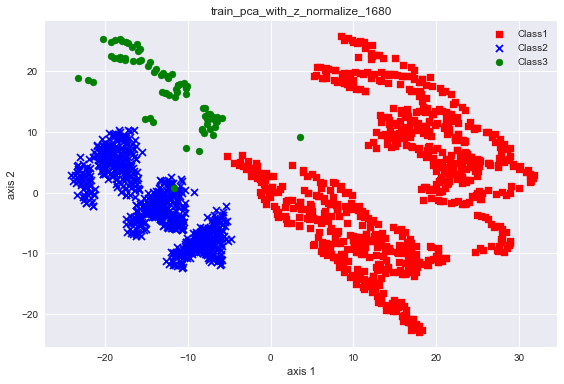

top_10 cumsum: [ 0.27010008  0.37351036  0.43553946  0.49129035  0.53582357  0.57185036
  0.60240169  0.62911655  0.65029473  0.66742224]


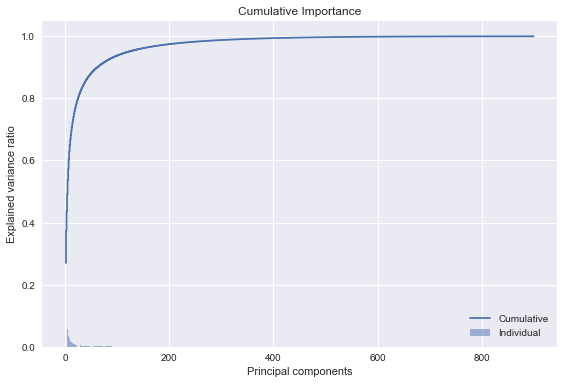

In [41]:
# now we have projection matrix P
# we can map data x into 2 dimension with Wx
pca_z = PCA(2, True)
pca_z.fit(train_df)
pca_z_data = np.dot(pca_z.P, pca_z._z_normalize(train_df).T) # W:k*900, img_df:sample*900, each column is a data
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(train_class.values), colors, markers):
    
    plt.scatter(pca_z_data[0, train_class.values==l], 
                pca_z_data[1, train_class.values==l],
                c=c, label=l, marker=m)

plt.title('train_pca_with_z_normalize_{}'.format(len(train_df)))
plt.xlabel('axis 1')
plt.ylabel('axis 2')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('train_pca_with_z_normalize_{}.png'.format(len(train_df)), dpi=300)
plt.show()

pca_z.show_importance_graph('z_fig-pca-var-exp.png')

In [11]:
#np.save('pca_matrix.npy', pca.P)

## 2_1 Probabilistic Generative Model

In [5]:
class GenerativeModel():
    
    def __init__(self):
        self.cov = None
        self.cov_det = None
        self.mu = {} # mu of each class
        self.class_count = {}
        self.class_names = None
        self.priors = {}
        self.likelihood_const = None
        self.D = None
        self.int_to_class_name = {}
        self.class_name_to_int = {}
        self.z = None
    
    def gen_data(self, gen_nb_dict=None, cov = None, return_data = False, plot=True):
        if gen_nb_dict is None:
            gen_nb_dict = {'Class1':100, 'Class2':100, 'Class3':100}
        if cov is None:
            cov = self.cov
            
        data_dict = {}
        for label in self.class_names:
            data_dict[label] = np.random.multivariate_normal(self.mu[label], cov, gen_nb_dict[label]).T
        colors = ['r', 'b', 'g']
        markers = ['s', 'x', 'o']
        if plot:
            for l, c, m in zip(self.class_names, colors, markers):
                plt.scatter(data_dict[l][0,:], data_dict[l][1,:],
                            c=c, label=l, marker=m)
            plt.title('generative_data')
            plt.xlabel('axis 1')
            plt.ylabel('axis 2')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.savefig('generative_data_{}_{}_{}.png'.format(gen_nb_dict['Class1'],gen_nb_dict['Class2'],gen_nb_dict['Class3']), dpi=300)
            plt.show()  
        if return_data:
            return data_dict
        
    def write_predictions(self, X, name=None):
        if name is None:
            X.to_csv('DemoTarget.csv', header=True)
        else:
            X.to_csv(name, header=True)
        
    def predict(self, X, one_hot=False, testing=False):
        
        X = X.copy()
        results = []
        mapping = {0:[1,0,0], 1:[0,1,0], 2:[0,0,1]}
        if one_hot == True and testing == True:
            for index, row in X.iterrows():
                posterioris = self.softmax(row)
                #softmax = self.softmax(row)
                max_key = max(posterioris, key=posterioris.get)
                #print(max_key)
                results.append(mapping[max_key])
            results = pd.DataFrame(results)
            return results
            
        else:
            posterioris = self.softmax(X)
            max_key = max(posterioris, key=posterioris.get)
            return max_key
        
    def softmax(self, data_point):
        posterioris = {}
        # joint probability
        for c in range(len(self.class_names)):
            posterioris[c] = self.likelihood(data_point, c) * self.priors[c]
        return posterioris
        exp_terms = [self.likelihood(data_point, c) for c in self.class_names]
        #posteriors = logsumexp(exp_terms, b=self.likelihood_const)
        # posteriori
        denominator = misc.logsumexp(exp_terms, b=self.likelihood_const)
        #denominator = np.exp(denominator)
        #denominator = np.sum(list(posterioris.values()))
        for c in range(len(self.class_names)):
            posterioris[c] /= denominator
        return posterioris
    
    def compute_mu(self, X, Y):
        X = X.copy()
        Y.index = range(len(Y))
        for label in Y.unique():
            #print(label)
            #print(X.iloc[Y[Y == label].index])
            self.mu[label] = X.iloc[Y[Y == label].index].mean(axis=0)
            #print(self.mu[label])
    
    def evaluate(self, X, Y, validation=False):
        X = X.copy()
        Y = Y.copy()
        if validation:
            for i in range(len(self.class_names)):
                Y[Y==self.class_names[i]] = i
        predict = X.apply(self.predict, axis=1)
        correct = len(Y[predict == Y])
        return correct / len(Y)
    
    def fit(self, X, Y, draw=True, plot_val=False, val_X=None, val_Y=None, verbose=1):
        """
        train: n_samples * 2
        target: n_samples * 1
        """
        self.class_names = np.sort(Y.unique())
        X = X.copy().astype(np.float64)
        Y = Y.copy()
        nb_classes = len(self.class_names)
        for i in range(nb_classes): # change the class name to integer
            self.class_name_to_int[self.class_names[i]] = i
            self.int_to_class_name[i] = self.class_names[i]
            Y[Y==self.class_names[i]] = i
            
#         for name, i in zip(self.class_names, range(len(self.class_names))):
#             #print(name, i)
#             Y[Y==name] = i
        
        self.compute_mu(X, Y)# compute mu vector of each class
        # count data points of each class
        for label in Y:
            self.class_count[label] = self.class_count.get(label, 0) + 1
        # use results above to be our prior
        for key in self.class_count.keys():
            self.priors[key] = self.class_count[key] / len(Y)
        self.D = X.shape[1] # nb_features
        self.cov = X.cov() # covariance matrix of training data
        self.cov_det = np.linalg.det(self.cov) # determinant of covariance matrix
        #print((2*np.pi)**(self.D/2), self.cov_det**0.5)
        self.likelihood_const = 1/((2*np.pi)**(self.D/2) * self.cov_det**0.5) # formula 4.64  
        print('training accuracy:', self.evaluate(X, Y))
        if val_X is not None and val_Y is not None:
            print('validation accuracy:', self.evaluate(val_X, val_Y, True))
        
        if draw: # draw decision boundary
            # 以training data為範圍
            if not plot_val:
                x_min, x_max = X.iloc[:, 0].min(), X.iloc[:, 0].max()
                y_min, y_max = X.iloc[:, 1].min(), X.iloc[:, 1].max()
            elif plot_val:
                x_min, x_max = val_X.iloc[:, 0].min(), val_X.iloc[:, 0].max()
                y_min, y_max = val_X.iloc[:, 1].min(), val_X.iloc[:, 1].max()
            x_min -= 0.1*abs(x_max - x_min)
            x_max += 0.1*abs(x_max - x_min)

            y_min -= 0.1*abs(y_max - y_min)
            y_max += 0.1*abs(y_max - y_min)
            r = abs(abs(x_max) - abs(x_min)) / 500
            xx, yy = np.meshgrid(np.arange(x_min, x_max, max(0.2,r)),
                                 np.arange(y_min, y_max, max(0.2,r)))
            
            # here is model's prediction (classification) function
            Z = []
            for data_point in np.c_[xx.ravel(), yy.ravel()]:
                Z.append(self.predict(data_point))
                #print(data_point)
            Z = np.array(Z)
            self.z = Z
            # put the result into a color plot
            # 1. decision boundary
            Z = Z.reshape(xx.shape)
            for c, i in zip(self.class_names, range(len(self.class_names))):
                Z[Z==c] = i
            plt.style.use('seaborn')
            #plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
            #plt.contourf(xx, yy, Z, cmap=plt.cm.CMRmap)
            #plt.contourf(xx, yy, Z, cmap=plt.cm.Accent)
            plt.contourf(xx, yy, Z, cmap=plt.cm.Paired_r)
            #plt.axis('off')
            
            colors = ['r', 'b', 'g']
            markers = ['s', 'x', 'o'] 
            
            # 2. training data points
            if not plot_val:
                for l, c, m in zip(range(len(self.class_names)), colors, markers):
                    l = self.int_to_class_name[l]
                    tmp = X.iloc[Y[Y == l].index]
                    plt.scatter(tmp.iloc[:,0], tmp.iloc[:,1],
                                c=c, label=l, marker=m)
                plt.title('GM_datas_with_boundary')
                plt.xlabel('axis 1')
                plt.ylabel('axis 2')
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('GM_datas_with_boundary.png', dpi=300)

                plt.show()
                plt.close()
            elif plot_val:
                for l, c, m in zip(range(len(self.class_names)), colors, markers):
                    l = self.int_to_class_name[l]
                    tmp = val_X.iloc[val_Y[val_Y == l].index]
                    plt.scatter(tmp.iloc[:,0], tmp.iloc[:,1],
                                c=c, label=l, marker=m)
                plt.title('GM_validation_with_boundary')
                plt.xlabel('axis 1')
                plt.ylabel('axis 2')
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('GM_validation_with_boundary.png', dpi=300)

                plt.show()
                plt.close()
        
    # the probability of data_point given class_name
    def likelihood(self, data_point, class_name):
        x_minus_mu = data_point - self.mu[class_name]
        exp_term = (-1/2) * np.dot(np.dot(x_minus_mu.T, np.linalg.inv(self.cov)), x_minus_mu)
        #p = self.likelihood_const * np.exp(exp_term)
        return exp_term

### Also compare the w; w/o z_normalization

可以看出未normalize的training/validation error都較差

training accuracy: 0.2898809523809524
validation accuracy: 0.27380952380952384


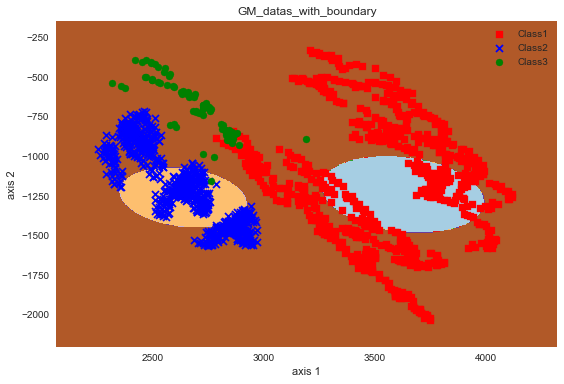

In [47]:
X_non_z = pd.DataFrame(pca_non_z_data.T) # n_samples * k
Y = train_class
pca_val_non_z = np.dot(pca_non_z.P, val_df.T)
X_val_non_z = pd.DataFrame(pca_val_non_z.T) # n_samples * k
Y_val = val_class
gen_non_z = GenerativeModel()
gen_non_z.fit(X_non_z, Y, val_X=X_val_non_z, val_Y=Y_val, plot_val=False)

training accuracy: 0.49464285714285716
validation accuracy: 0.4595238095238095


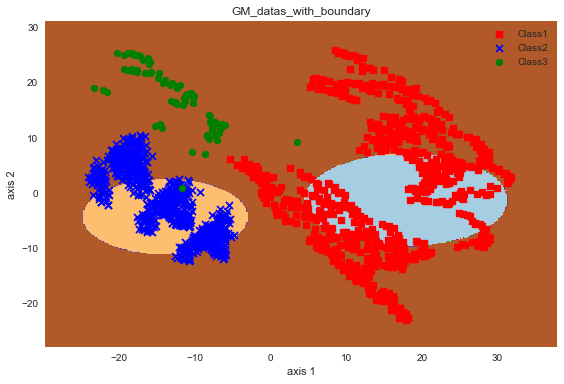

In [46]:
X_z= pd.DataFrame(pca_z_data.T) # n_samples * k
Y = train_class
pca_val_z = np.dot(pca_z.P, pca_z._z_normalize(val_df).T)
X_val_z = pd.DataFrame(pca_val_z.T) # n_samples * k
Y_val = val_class
gen_z = GenerativeModel()
gen_z.fit(X_z, Y, val_X=X_val_z, val_Y=Y_val, plot_val=False)

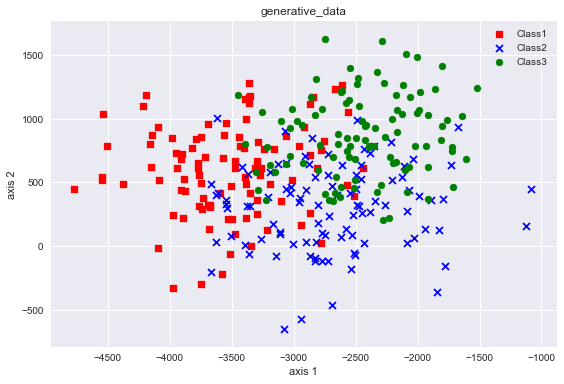

In [18]:
# 試生成一下
gen_non_z.gen_data(gen_nb_dict={'Class1':100, 'Class2':100, 'Class3':100},cov=gen_non_z.cov)

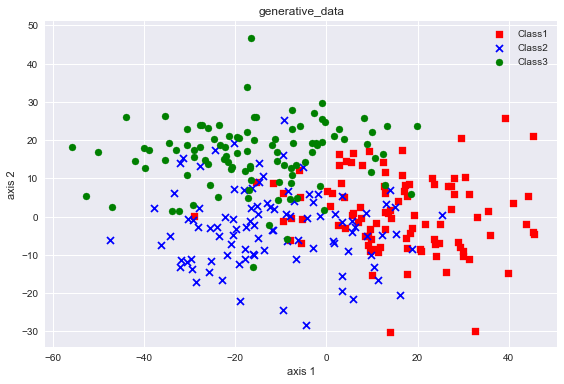

In [151]:
# 試生成一下
gen_z.gen_data(cov=gen_z.cov)

## 2_2 Probabilistic Discriminative Model

In [6]:
class DiscriminativeModel():
    
    def __init__(self):
        self.w = None
        self.class_names = None
        self.int_to_class_name = {} # used to map integer class to string class name
        self.seesee = {} # used for debugging
        
    def _softmax(self, X, W=None):
        """Compute softmax with dot(W, X)
        
        Args:
            X (DataFrame): inputs for prediction
            W (Array like): used to compute dot(W, X)

        Returns:
            list: one-hot encoding, summation should be 1, the value is the "convidence" of each class
        """
        if W is None:
            if self.w is None:
                W = np.random.random(size=(3,3))
            else:
                W = self.w
        if type(X) == tuple:
            X = np.array(X)
#            W = self.w
        #print(W.shape)
        # X: nb_features * nb_datas
        # W: nb_features * nb_classes
        #print(W.shape, X.shape)
        a_ks = np.dot(W.T, X.T) # a: nb_classes * nb_datas
        large_const = np.max(a_ks) # use to prevent overflow
        # p(c_k|x) for each k, nb_classes * nb_datas
        results = np.exp(a_ks-large_const) / (np.sum(np.exp(a_ks - large_const), axis=0))
        return results
    
    def write_predictions(self, X, name=None):
        if name is None:
            X.to_csv('DemoTarget.csv', header=True)
        else:
            X.to_csv(name, header=True)
    
    def evaluate(self, X, Y, write_predictions=True):
        """Evaluate given data
        
        Args:
            X (DataFrame): inputs for prediction
            Y (DataFrame): target value

        Returns:
            float: accuracy of the data set
        """
        X = X.copy().astype(np.float64)
        Y = Y.copy()
        if X.shape[1] == 2:
            X[X.shape[1]] = 1
        elif X.shape[1] != 3:
            print('dimension of data should be 2')
            return
        for name, i in zip(self.class_names, range(len(self.class_names))):
            #print(name, i)
            Y[Y==name] = i
        #Y.astype(np.float64)
        predict = X.apply(self.predict, axis=1)
        one_hot_predict = X.apply(self.predict, args=([True]), axis=1)
        self.seesee['predict_values'] = predict
        self.seesee['one_hot_predict_values'] = one_hot_predict
        correct = len(Y[predict == Y])
        return correct / len(Y)
    
    def predict(self, X, one_hot=False, testing=False):
        """Predict given data, todo: vectorize
        
        Args:
            X (DataFrame): inputs for prediction

        Returns:
            list or integer: accuracy of the data set
        """
        X = X.copy()
        if testing:
            if X.shape[1] == 2:
                X[X.shape[1]] = 1
            elif X.shape[1] != 3:
                print('dimension of data should be 2')
                return
        
        mapping = {0:[1,0,0], 1:[0,1,0], 2:[0,0,1]}
        results = []
        if type(X) == tuple or type(X) == pd.Series:
            if type(X) == tuple:
                softmax = self._softmax(np.array(X))
            else:
                softmax = self._softmax(X.astype(np.float32))
            #print(softmax)
            if one_hot:
                results = mapping[np.argmax(softmax)]
            else:
                results = np.argmax(softmax)
        elif type(X) == np.ndarray:
            softmax = self._softmax(X)
            results = np.argmax(softmax)
        else:
            for index, row in X.iterrows():
                softmax = self._softmax(row)
                if one_hot:
                    results.append(mapping[np.argmax(softmax, axis=0)])
                else:
                    results.append(np.argmax(softmax, axis=0))
            results = pd.DataFrame(results)
        return results
    
    def fit(self, X, target, iteration_limit=20, converge=0.003, 
            val_X=None, val_Y=None, method='newton', early_stopping=True,
            draw=True, plot_val=False):
        """Train the model
        
        Args:
            X (DataFrame): inputs for prediction
            t (DataFrame): target
            iteration_limit (int): the max iteration numbers for the update algorithm
            converge (float): check the weight converged or not, norm(w_new-w_old)/norm(w_old)
            val_X (DataFrame): validation inputs for evaluation
            val_X (DataFrame): validation target for evaluation
            method (string): how to update weights, todo: add SGD
            early_stopping (bool): only works when give validation set, prevent overfitting
            draw (bool): enabble plot graph and decision boundary
            plot_val (bool): True->plot validation set; False:->plot training data
        Returns:
            None
        """
        t = target.copy() # nb_datas * 1
        X = X.copy() # nb_datas * nb_features
        N = len(X) # nb_datas

        # add a column with the values=1 if not added
        # for simplicity, constrain the dimension of input = 2
        if X.shape[1] == 2:
            X[X.shape[1]] = 1
        elif X.shape[1] != 3:
            print('dimension of data should be 2')
            return
        
        self.class_names = np.sort(t.unique())
        nb_classes = len(self.class_names)
        for i in range(nb_classes): # change the class name to integer
            self.int_to_class_name[i] = self.class_names[i]
            t[t==self.class_names[i]] = i
        t_int = t.values.astype(np.int) # target w/o one-hot
        T = np.eye(nb_classes)[t_int] # one-hot target, nb_datas * nb_classes
        
        ################### Initialize the weights ################### 
        # weights column by column ([w1, w2, w3] in this case)
        np.random.seed(0)
        #W_old = np.zeros((X.shape[1], nb_classes))
        W_old = np.random.randn(X.shape[1]*nb_classes).reshape((X.shape[1], nb_classes))/np.sqrt(len(X))
        #W_old = np.random.random((X.shape[1], nb_classes))
        
        
        ################## update the weights ################### 
        for iter_num in range(iteration_limit):
            Y = np.zeros((N, nb_classes)) # predictions, each row is an one-hot prediciton of one data poin
            for i in range(N):
                Y[i,:] = self._softmax(X.iloc[i]) # prediction
            H = np.zeros((nb_classes**2, X.shape[1], X.shape[1])) # hessian
            I = np.eye((nb_classes))
            for j in range(nb_classes):
                for k in range(nb_classes):
                    # 對於特定的wk, wj求 Hessian matrix
                    for n in range(len(X)):
                        # ppt p.37
                        #print(Y[n,k], I[k,j], Y[n,j])
                        constant = Y[n, k] * (I[k, j] - Y[n, j])
                        if constant == 0:
                            constant = 1e-150 # 避免讓hessian變為singular
                        x = X.iloc[n].values.reshape((1, X.shape[1]))
                        matrix = np.matrix(x.T) * np.matrix(x) # (nb_features+1) x (nb_beatures+1)
                        H[k+j*nb_classes] += constant * matrix
            W_new = np.zeros((X.shape[1], nb_classes))
            # 對於特定的wj求gradient
            for i in range(nb_classes):
                #print(Y.shape, T.shape)
                E_gradient = np.dot((Y[:,i]-T[:,i]).T, X)
                #print('e_gradient:', E_gradient.shape)
                W_new[:,i] = W_old[:,i] - np.dot(np.linalg.inv(H[i + i * nb_classes]), E_gradient)

                    
            
            # check convergence
            differ = np.linalg.norm(W_new - W_old) / np.linalg.norm(W_old)

            print(iter_num, differ)
            #print(W_old)
            #print(W_new)
            W_old = W_new
            self.w = W_new

            train_acc = self.evaluate(X, t)
            print('trainning accuracy:', train_acc)
            if val_X is not None and val_Y is not None:
                validation_acc = self.evaluate(val_X, val_Y)
                print('validation accuracy:', validation_acc)
            if differ < converge:
                print('converged!')
                break
        else:
            print('max iteration reached, may not convergence')
            
        ######################## plot part ############################
        if draw: # draw decision boundary
            if not plot_val:
                x_min, x_max = X.iloc[:, 0].min(), X.iloc[:, 0].max()
                y_min, y_max = X.iloc[:, 1].min(), X.iloc[:, 1].max()
            elif plot_val:
                x_min, x_max = val_X.iloc[:, 0].min(), val_X.iloc[:, 0].max()
                y_min, y_max = val_X.iloc[:, 1].min(), val_X.iloc[:, 1].max()
            x_min -= 0.1*abs(x_max - x_min)
            x_max += 0.1*abs(x_max - x_min)

            y_min -= 0.1*abs(y_max - y_min)
            y_max += 0.1*abs(y_max - y_min)
            r = abs(abs(x_max) - abs(x_min)) / 500
            xx, yy = np.meshgrid(np.arange(x_min, x_max, max(0.2,r)),
                                 np.arange(y_min, y_max, max(0.2,r)))

            # here is model's prediction (classification) function
            Z = []
            for data_point in np.c_[xx.ravel(), yy.ravel()]:
                data_point = np.insert(data_point, len(data_point), values=1)
                Z.append(self.predict(data_point))
            Z = np.array(Z)
            self.z = Z
            # put the result into a color plot
            # 1. decision boundary
            Z = Z.reshape(xx.shape)
            plt.style.use('seaborn')
            #plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
            #plt.contourf(xx, yy, Z, cmap=plt.cm.CMRmap)
            #plt.contourf(xx, yy, Z, cmap=plt.cm.Accent)
            plt.contourf(xx, yy, Z, cmap=plt.cm.Paired_r)
            #plt.axis('off')
            
            colors = ['r', 'b', 'g']
            markers = ['s', 'x', 'o'] 
            
            # 2. training data points
            if not plot_val:
                for l, c, m in zip(range(len(self.class_names)), colors, markers):
                    l = self.int_to_class_name[l]
                    tmp = X.iloc[target[target == l].index]
                    plt.scatter(tmp.iloc[:,0], tmp.iloc[:,1],
                                c=c, label=l, marker=m)
                plt.title('DM_datas_with_boundary')
                plt.xlabel('axis 1')
                plt.ylabel('axis 2')
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('DM_datas_with_boundary.png', dpi=300)

                plt.show()
                plt.close()
            elif plot_val:
                for l, c, m in zip(range(len(self.class_names)), colors, markers):
                    l = self.int_to_class_name[l]
                    tmp = val_X.iloc[val_Y[val_Y == l].index]
                    plt.scatter(tmp.iloc[:,0], tmp.iloc[:,1],
                                c=c, label=l, marker=m)
                plt.title('DM_validation_with_boundary')
                plt.xlabel('axis 1')
                plt.ylabel('axis 2')
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('DM_validation_with_boundary.png', dpi=300)

                plt.show()
                plt.close()

In [130]:
dm_z.write_predictions(dm_z.seesee['one_hot_predict_values'])

In [131]:
results = dm_z.predict(X_z, True, True)
results['target'] = Y

0 68.1382490812
Class1 0
Class2 1
Class3 2
trainning accuracy: 0.9494047619047619
Class1 0
Class2 1
Class3 2
validation accuracy: 0.95
1 164.384282352
Class1 0
Class2 1
Class3 2
trainning accuracy: 0.05238095238095238
Class1 0
Class2 1
Class3 2
validation accuracy: 0.05476190476190476
2 2.2443667645e+40
Class1 0
Class2 1
Class3 2
trainning accuracy: 0.39166666666666666
Class1 0
Class2 1
Class3 2
validation accuracy: 0.38571428571428573
3 2.88654303404e+106
Class1 0
Class2 1
Class3 2
trainning accuracy: 0.5863095238095238
Class1 0
Class2 1
Class3 2
validation accuracy: 0.5761904761904761
4 0.671103752874
Class1 0
Class2 1
Class3 2
trainning accuracy: 0.9523809523809523
Class1 0
Class2 1
Class3 2
validation accuracy: 0.9452380952380952
5 0.0795386008799
Class1 0
Class2 1
Class3 2
trainning accuracy: 0.9523809523809523
Class1 0
Class2 1
Class3 2
validation accuracy: 0.9452380952380952
6 0.0783468718041
Class1 0
Class2 1
Class3 2
trainning accuracy: 0.9696428571428571
Class1 0
Class2 1
Cla

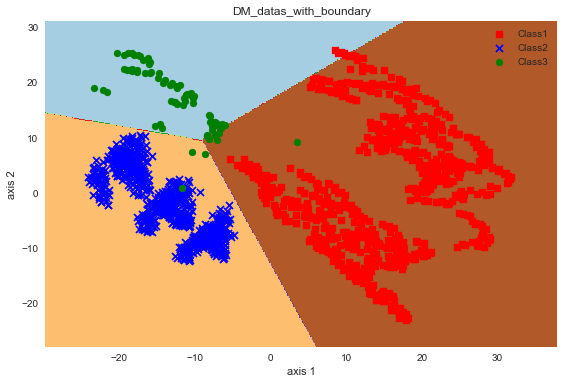

In [129]:
dm_z= DiscriminativeModel()
dm_z.fit(X_z, train_class, val_X=X_val_z, val_Y=Y_val)

In [50]:
dm_z= DiscriminativeModel()
dm_z.fit(X_z, train_class, val_X=X_val_z, val_Y=Y_val, plot_val=True)

0 60.7611441105
trainning accuracy: 0.9452380952380952
validation accuracy: 0.9404761904761905


KeyboardInterrupt: 

0 9489900.42169
trainning accuracy: 0.5232142857142857
validation accuracy: 0.530952380952381
1 3.20803948824e+17
trainning accuracy: 0.1761904761904762
validation accuracy: 0.1761904761904762
2 1.44394268362e+127
trainning accuracy: 0.7922619047619047
validation accuracy: 0.7642857142857142
3 0.200407242401
trainning accuracy: 0.9119047619047619
validation accuracy: 0.9047619047619048
4 0.14973820132
trainning accuracy: 0.9261904761904762
validation accuracy: 0.930952380952381
5 0.155829137394
trainning accuracy: 0.9410714285714286
validation accuracy: 0.9428571428571428
6 0.133924569499
trainning accuracy: 0.944047619047619
validation accuracy: 0.9428571428571428
7 0.112479453863
trainning accuracy: 0.9595238095238096
validation accuracy: 0.9619047619047619
8 0.0211129017785
trainning accuracy: 0.9583333333333334
validation accuracy: 0.969047619047619
9 0.0247531765685
trainning accuracy: 0.9672619047619048
validation accuracy: 0.9714285714285714
10 0.0182828200152
trainning accuracy

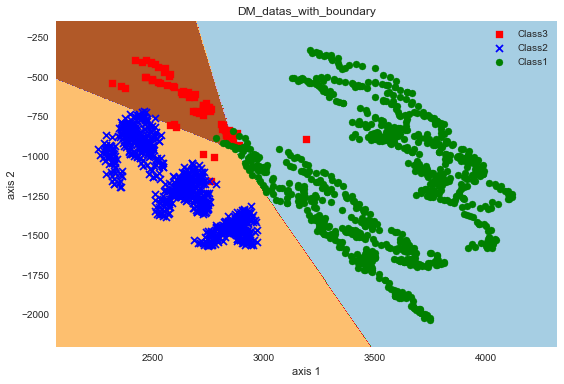

In [51]:
dm_non_z= DiscriminativeModel()
dm_non_z.fit(X_non_z, train_class, val_X=X_val_non_z, val_Y=Y_val)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:165: RuntimeWarning: divide by zero encountered in double_scalars


0 inf
trainning accuracy: 0.9119047619047619
validation accuracy: 0.9023809523809524
1 2.10532011551e+13
trainning accuracy: 0.7130952380952381
validation accuracy: 0.7023809523809523
2 1.41104537622e+132
trainning accuracy: 0.669047619047619
validation accuracy: 0.6738095238095239
3 1.07194922397
trainning accuracy: 0.8464285714285714
validation accuracy: 0.8261904761904761
4 0.2360525121
trainning accuracy: 0.95
validation accuracy: 0.9476190476190476
5 0.224307276921
trainning accuracy: 0.9595238095238096
validation accuracy: 0.9571428571428572
6 0.160245360521
trainning accuracy: 0.9761904761904762
validation accuracy: 0.969047619047619
7 0.061816145049
trainning accuracy: 0.9642857142857143
validation accuracy: 0.969047619047619
8 0.0484518279736
trainning accuracy: 0.9696428571428571
validation accuracy: 0.969047619047619
9 0.035897218898
trainning accuracy: 0.9583333333333334
validation accuracy: 0.9619047619047619
10 0.0873352982366
trainning accuracy: 0.9726190476190476
valida

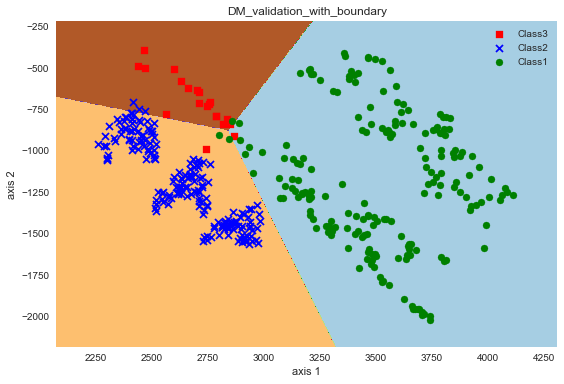

In [156]:
dm_non_z= DiscriminativeModel()
dm_non_z.fit(X_non_z, train_class, val_X=X_val_non_z, val_Y=Y_val, plot_val=True)

### 以下Demo用

In [7]:
# initialize and PCA
img_width = 30
img_height = 30

file_path = 'Data_Train'
class_names = ['Class1', 'Class2', 'Class3']
train_df, train_class, val_df, val_class = get_data(file_path=file_path, class_names=class_names,
                                                    validation_ratio=0) 
pca_z = PCA(2, True)
pca_z.fit(train_df)
pca_z_data = np.dot(pca_z.P, pca_z._z_normalize(train_df).T)

X_z= pd.DataFrame(pca_z_data.T) # n_samples * k
Y = train_class
# pca_val_z = np.dot(pca_z.P, pca_z._z_normalize(val_df).T)
# X_val_z = pd.DataFrame(pca_val_z.T) # n_samples * k
# Y_val = val_class

Data_Train/Class1/
Data_Train/Class2/
Data_Train/Class3/


In [8]:
# train models
gen_z = GenerativeModel()
gen_z.fit(X_z, Y, draw=False)
dm_z= DiscriminativeModel()
dm_z.fit(X_z, train_class, draw=False)

training accuracy: 0.9583333333333334
0 23.2046410765
trainning accuracy: 0.9823333333333333
1 1.18411450053
trainning accuracy: 0.6623333333333333
2 7.99584241654
trainning accuracy: 0.225
3 58410.9570327
trainning accuracy: 0.7516666666666667
4 2.04785292529e+143
trainning accuracy: 0.39266666666666666
5 1.11071768835
trainning accuracy: 0.6756666666666666
6 1.59498251385
trainning accuracy: 0.9016666666666666
7 0.43591611485
trainning accuracy: 0.9503333333333334
8 0.308737375985
trainning accuracy: 0.9673333333333334
9 0.213077369859
trainning accuracy: 0.975
10 0.161883018418
trainning accuracy: 0.9813333333333333
11 0.112024633638
trainning accuracy: 0.9823333333333333
12 0.103698014319
trainning accuracy: 0.9853333333333333
13 0.0781697338887
trainning accuracy: 0.9866666666666667
14 0.0619484687019
trainning accuracy: 0.987
15 0.0501404112899
trainning accuracy: 0.985
16 0.0319781828115
trainning accuracy: 0.9863333333333333
17 0.0281743365732
trainning accuracy: 0.985
18 0.026

In [57]:
# testing
file_path = 'Demo'
class_names=None
demo = get_data(file_path=file_path, class_names=class_names)
pca_demo_data = np.dot(pca_z.P, pca_z._z_normalize(demo).T)
# demo = pd.DataFrame(np.random.random((600, 900)))
# pca_demo_data = np.dot(pca_z.P, pca_z._z_normalize(demo).T)
demo_input = pd.DataFrame(pca_demo_data.T)

['1.bmp', '2.bmp', '3.bmp', '4.bmp', '5.bmp', '6.bmp', '7.bmp', '8.bmp', '9.bmp', '10.bmp', '11.bmp', '12.bmp', '13.bmp', '14.bmp', '15.bmp', '16.bmp', '17.bmp', '18.bmp', '19.bmp', '20.bmp', '21.bmp', '22.bmp', '23.bmp', '24.bmp', '25.bmp', '26.bmp', '27.bmp', '28.bmp', '29.bmp', '30.bmp', '31.bmp', '32.bmp', '33.bmp', '34.bmp', '35.bmp', '36.bmp', '37.bmp', '38.bmp', '39.bmp', '40.bmp', '41.bmp', '42.bmp', '43.bmp', '44.bmp', '45.bmp', '46.bmp', '47.bmp', '48.bmp', '49.bmp', '50.bmp', '51.bmp', '52.bmp', '53.bmp', '54.bmp', '55.bmp', '56.bmp', '57.bmp', '58.bmp', '59.bmp', '60.bmp', '61.bmp', '62.bmp', '63.bmp', '64.bmp', '65.bmp', '66.bmp', '67.bmp', '68.bmp', '69.bmp', '70.bmp', '71.bmp', '72.bmp', '73.bmp', '74.bmp', '75.bmp', '76.bmp', '77.bmp', '78.bmp', '79.bmp', '80.bmp', '81.bmp', '82.bmp', '83.bmp', '84.bmp', '85.bmp', '86.bmp', '87.bmp', '88.bmp', '89.bmp', '90.bmp', '91.bmp', '92.bmp', '93.bmp', '94.bmp', '95.bmp', '96.bmp', '97.bmp', '98.bmp', '99.bmp', '100.bmp', '101.bm

In [58]:
# write results
dm_z.write_predictions(dm_z.predict(demo_input, True, True), 'dm_test.csv')
gen_z.write_predictions(gen_z.predict(demo_input, True, True), 'gen_test.csv')

In [61]:
f = open('gen_test.csv')
lines = f.readlines()

In [62]:
r = open('gen_test.txt', 'w')
for line in lines[1:]:
    print(line[line.find(',')+1:])
    r.write(line[line.find(',')+1:])
r.close()

0,0,1

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

0,1,0

1,0,0

0,1,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

0,1,0

1,0,0

1,0,0

0,1,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0

1,0,0


In [40]:
# write results
dm_z.write_predictions(dm_z.predict(X_z, True, True), 'dm_train.csv')
gen_z.write_predictions(gen_z.predict(X_z, True, True), 'gen_train.csv')